In [1]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import skimage.io as io
import cv2
from pycocotools.coco import COCO
import json
import shutil


In [ ]:
'''Categories:
=========
  super_category: person
    id 1: nondisabledped
    id 2: wheelchairped
    id 3: visuallyimpairedped
    id 4: rider

  super_category: vehicle
    id 5: fourwheelveh
    id 6: twowheelveh

  super_category: aid
    id 8: cane
    id 7: wheelchair'''

In [5]:
'''
COCO Dataset path
'''

coco = COCO('./Data_NoTemporal/rev_val_xworld.json')  
img_dir = './Data_NoTemporal/rev_val_xworld/'

# get all ids
cat_ids = coco.getCatIds()

loading annotations into memory...
Done (t=2.48s)
creating index...
index created!


In [6]:
cat_ids

[1, 2, 3, 4, 5, 6, 7, 8]

In [7]:
''' 
get the image ids for specific/filtered category ids 
here this code is inputting all category ids 
'''
imgIds = coco.getImgIds(catIds=[5])


In [1]:
# imgIds

In [8]:
# imgIds

image_id = 20000024374 #30000087080 #10000000640  #10000102266    #10000000005   #10000000002 #10000000000  #10000000001 #

img = coco.imgs[image_id]

In [9]:
img


{'license': None,
 'file_name': '020000024374.jpg',
 'coco_url': None,
 'height': 1080,
 'width': 1920,
 'date_captured': 'Thu Feb 16 14:00:30 2023',
 'flickr_url': None,
 'id': 20000024374,
 'weather': 'MidRainSunset',
 'town': 'Town02',
 'type': 'walker',
 'sequence_info': {'sequence_id': 200018,
  'frame_id': 30,
  'total_frames': 101,
  'pos': 'front'}}

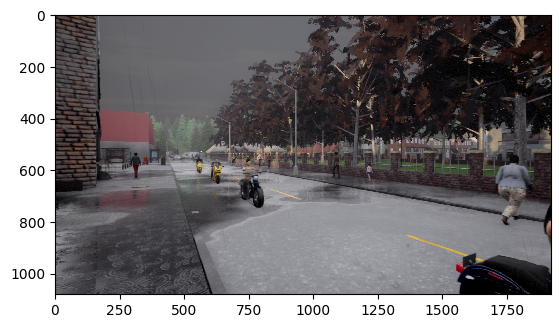

In [10]:
#plot image
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.show()

0

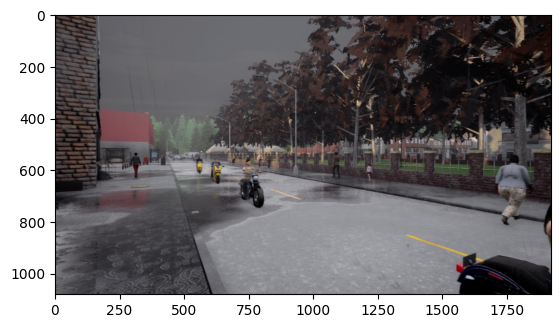

In [11]:
#plot mask

plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=[5], iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

In [12]:
''' 
For printing bboxes
'''
for ann in anns:
    print(ann['bbox'])

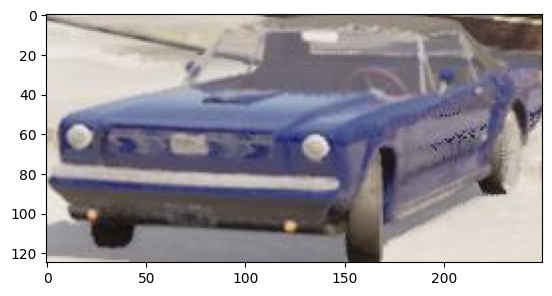

In [21]:
im=image[588:713, 814:1064]
plt.imshow(im)

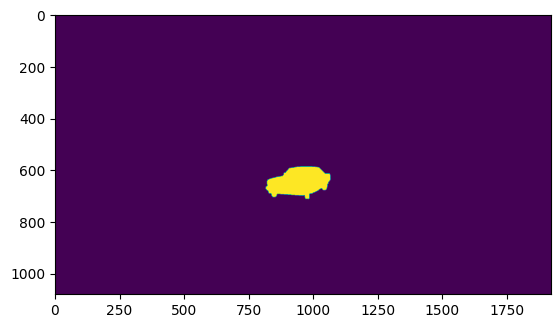

In [22]:

anns_img = np.zeros((img['height'],img['width']))
for ann in anns:
    mask=coco.annToMask(ann)
    # anns_img[mask > 0] = ann['category_id']
    anns_img = np.maximum(anns_img,mask*ann['category_id'])

plt.imshow(anns_img)


In [26]:
im = np.where(anns_img==5, 1, 0)

In [31]:
plt.imsave('10000072718.png',im)

In [28]:
np.unique(im)

array([0, 1])

In [23]:
''' Unique Category ids in image'''
np.unique(anns_img)

array([0., 5.])

In [ ]:
'''

Save Masks 

'''

In [19]:
''' There are some images which has no mask or bboxes or any annotations which will cause error in the trianing code. This code will 
ensure that there are image Ids existing with no annotations'''


# Load COCO annotation file
coco_ann_file = './Data_NoTemporal/revised_train_xworld.json'  

# Load COCO annotations
coco_data = COCO(coco_ann_file)


# Iterate through each image
for img_id in coco_data.getImgIds():

    # Get annotations for the image
    ann_ids = coco_data.getAnnIds(imgIds=img_id)
    anns = coco_data.loadAnns(ann_ids)

    ''' This image id is having empty annotation '''

    if img_id==10000000001:
        print('Image Id of empty annotation is :',img_id)
        print(anns)
        
    # Convert COCO annotation to mask
    if len(anns)==0:
        print(anns)
        print(img_id)



loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [23]:
'''
There is ambiguity in bboxes as per coco standard format is [x, y, w, h] but there are some bboxes which are in the form of 
[x_min, y_min, x_max, y_max] and [x_min, y_min, x_max, y_max] is the expected format for the model we will be working on. This code 
is a check code for the same Hypothesis.

'''

# Load COCO annotation file
coco_ann_file = './Data_NoTemporal/val_xworld.json'

# Load COCO annotations
coco_data = COCO(coco_ann_file)


# Iterate through each image
for img_id in coco_data.getImgIds():
   
    # Get annotations for the image
    ann_ids = coco_data.getAnnIds(imgIds=img_id)
    anns = coco_data.loadAnns(ann_ids)

    for ann in anns:

        if  (ann['bbox'][0]>ann['bbox'][2] or ann['bbox'][1]>ann['bbox'][3]):
            print(img_id)
            print(ann['bbox'])
        

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [3]:
def is_valid_bbox(box):
    width = box[2] - box[0]
    height = box[3] - box[1]
    return width > 0 and height > 0 and width !=0 and height !=0


In [20]:
'''This code resolves the bounding boxes format and no annotations image ids by filtering out those which has no annotation and 
changing the bboxes format. '''

# Load the COCO annotations
coco_data = COCO('./Data_NoTemporal_orig/val_xworld.json')

new_annotations = []
new_images = []
target_folder = './Data_NoTemporal/rev_val_xworld/'

# Loop over all the images in the dataset
for img_id in coco_data.getImgIds():
    # Get the annotation ids for the current image

    img_info = coco_data.loadImgs(img_id)[0]
    img_path = './Data_NoTemporal_orig/images/val_xworld/' + img_info['file_name'] 
    ann_ids = coco_data.getAnnIds(imgIds=img_id)

    # Load the annotations
    anns = coco_data.loadAnns(ann_ids)
    
    # Check if the annotations list is not empty
    if anns != []:
        # Loop over the annotations for the current image
        for ann in anns:

            # else:
            ann['bbox'][2]=ann['bbox'][0]+ann['bbox'][2]
            ann['bbox'][3]=ann['bbox'][1]+ann['bbox'][3]
            if is_valid_bbox(ann['bbox']):
                new_annotations.append(ann)
                new_images.append(img_info)
                shutil.copy(img_path, target_folder + img_info['file_name'])

# Replace the annotations and images in the original data with the new annotations
coco_data.dataset['annotations'] = new_annotations
coco_data.dataset['images'] = new_images

# Save the revised annotations back to disk
with open('rev_val_xworld.json', 'w') as f:  # replace with your desired output file
    json.dump(coco_data.dataset, f)

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!


In [3]:
'''To remove images with no instances '''

# Load the COCO annotations
coco_data = COCO('./Data_NoTemporal_orig/train_xworld.json')

new_annotations = []
new_images = []
target_folder = './Data_NoTemporal_cleaned_orig/train_xworld/'

# Loop over all the images in the dataset
for img_id in coco_data.getImgIds():
    # Get the annotation ids for the current image

    img_info = coco_data.loadImgs(img_id)[0]
    img_path = './Data_NoTemporal_orig/images/train_xworld/' + img_info['file_name'] 
    ann_ids = coco_data.getAnnIds(imgIds=img_id)

    # Load the annotations
    anns = coco_data.loadAnns(ann_ids)
    
    # Check if the annotations list is not empty
    if anns != []:
        # Loop over the annotations for the current image
        for ann in anns:

            # # else:
            # ann['bbox'][2]=ann['bbox'][0]+ann['bbox'][2]
            # ann['bbox'][3]=ann['bbox'][1]+ann['bbox'][3]
            # if is_valid_bbox(ann['bbox']):
            new_annotations.append(ann)
            new_images.append(img_info)
            shutil.copy(img_path, target_folder + img_info['file_name'])

# Replace the annotations and images in the original data with the new annotations
coco_data.dataset['annotations'] = new_annotations
coco_data.dataset['images'] = new_images

# Save the revised annotations back to disk
with open('train_xworld.json', 'w') as f:  # replace with your desired output file
    json.dump(coco_data.dataset, f)

loading annotations into memory...
Done (t=3.32s)
creating index...
index created!


In [3]:
'''  
This saves category ids as pixel value (INSTANCE SEGMENTATION)
'''


# Load COCO annotation file
coco_ann_file = './Data_NoTemporal_cleaned_orig/train_xworld.json'  

# Load COCO annotations
coco_data = COCO(coco_ann_file)

# Get category information
categories = coco_data.loadCats(coco_data.getCatIds())
category_ids = [cat['id'] for cat in categories]


# Iterate through each image
for img_id in coco_data.getImgIds():
    
    # Load image
    img_info = coco_data.loadImgs(img_id)[0]
    img_path = './Data_NoTemporal_cleaned_orig/train_xworld/' + img_info['file_name']  # Replace with your image directory path
    image = io.imread(img_path)

    # Initialize empty mask image
    mask_image = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    # Get annotations for the image
    ann_ids = coco_data.getAnnIds(imgIds=img_id)
    anns = coco_data.loadAnns(ann_ids)
    
    # Iterate through each annotation
    for ann in anns:
        # Convert COCO annotation to mask
        mask = coco_data.annToMask(ann)

        mask_image[mask > 0] = ann['category_id']
        # mask_image = np.maximum(mask_image, mask*ann['category_id'])


    # Save the mask image
    mask_path = './Data_NoTemporal_cleaned_orig/train_xworld_masks/' + img_info['file_name'].replace('.jpg', '.png') # make sure to save as png
    Image.fromarray(mask_image).save(mask_path)


loading annotations into memory...
Done (t=3.28s)
creating index...
index created!


In [3]:
'''To remove images with no instances UPDATE'''


coco_data = COCO('./Data_NoTemporal_orig/val_xworld.json')

new_annotations = []
new_images = []
target_folder = './Data_NoTemporal_cleaned_orig/val_xworld/'

# Loop over all the images in the dataset
for img_id in coco_data.getImgIds():
    # Get the annotation ids for the current image
    img_info = coco_data.loadImgs(img_id)[0]
    img_path = './Data_NoTemporal_orig/images/val_xworld/' + img_info['file_name'] 
    ann_ids = coco_data.getAnnIds(imgIds=img_id)

    # Load the annotations
    anns = coco_data.loadAnns(ann_ids)
    
    # Check if the annotations list is not empty
    if anns != []:
        # The image is added to the new_images list only once
        new_images.append(img_info)
        shutil.copy(img_path, target_folder + img_info['file_name'])

        # Loop over the annotations for the current image
        for ann in anns:
            new_annotations.append(ann)

# Replace the annotations and images in the original data with the new annotations
coco_data.dataset['annotations'] = new_annotations
coco_data.dataset['images'] = new_images

# Save the revised annotations back to disk
with open('val_xworld.json', 'w') as f:  # replace with your desired output file
    json.dump(coco_data.dataset, f)


loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


In [ ]:
'''
In case of Semantic segmentation following code will be helpful in converting annotations to Masks

'''

# Load COCO annotation file
coco_ann_file = './Data_NoTemporal/val_xworld.json'  # Replace with your annotation file path

# Load COCO annotations
coco_data = COCO(coco_ann_file)

# Get category information
categories = coco_data.loadCats(coco_data.getCatIds())
category_ids = [cat['id'] for cat in categories]

# Define color map or label map for instances
# color_map = {cat_id: (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
            #  for cat_id in category_ids}

color_map = {
    1: [255, 0, 0],    # Category 1 - Red
    2: [0, 255, 0],    # Category 2 - Green
    3: [0, 0, 255],    # Category 3 - Blue
    4: [255, 255, 0],  # Category 4 - Yellow
    5: [255, 0, 255],  # Category 5 - Magenta
    6: [0, 255, 255],  # Category 6 - Cyan
    7: [128, 128, 128],  # Category 7 - Gray
    8: [255, 255, 255],  # Category 8 - White
}

# Iterate through each image
for img_id in coco_data.getImgIds():
    # Load image
    img_info = coco_data.loadImgs(img_id)[0]
    img_path = './Data_NoTemporal/images/val_xworld/' + img_info['file_name']  # Replace with your image directory path
    image = io.imread(img_path)

    # Initialize empty mask image
    mask_image = np.zeros((img_info['height'], img_info['width'], 3), dtype=np.uint8)

    # Get annotations for the image
    ann_ids = coco_data.getAnnIds(imgIds=img_id)
    anns = coco_data.loadAnns(ann_ids)

    # Iterate through each annotation
    for ann in anns:
        # Convert COCO annotation to mask
        mask = coco_data.annToMask(ann)

        # Get the category ID for the instance
        cat_id = ann['category_id']

        # Assign a color or label to the instance mask
        color = color_map[cat_id]
        mask_image[mask == 1] = color  # Assign the color to the mask
        # Or, if using label map instead of color map
        # mask_image[mask == 1] = label_map[cat_id]  # Assign the label to the mask

    # Save the mask image
    mask_path = './Data_NoTemporal/train_xworld_masks/' + img_info['file_name'].replace('.jpg', '.png') # make sure to save as png
    Image.fromarray(mask_image).save(mask_path)


In [39]:
from pycocotools.coco import COCO
import json

# Load COCO annotations
coco = COCO('./Data_NoTemporal/rev_train_xworld.json')  # Replace with your file path

# Get ids of images that contain the category of interest
category_ids = coco.getCatIds(catNms=['twowheelveh'])  # Replace with your category name
image_ids = coco.getImgIds(catIds=category_ids)

# Get only the annotations that correspond to the category of interest
annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_ids, catIds=category_ids))

# Create a new JSON file with only the annotations of interest
with open('filtered_annotations.json', 'w') as f:
    json.dump(annotations, f)


loading annotations into memory...
Done (t=3.94s)
creating index...
index created!


In [9]:
import json
import os

# Load the validation annotations
with open('./Data_NoTemporal_cleaned_orig/val_xworld.json') as f:
    val_data = json.load(f)

# Check for empty annotations and inconsistent image ids
empty_ann_image_ids = []
inconsistent_image_ids = []
image_ids = [img['id'] for img in val_data['images']]
image_files = [img['file_name'] for img in val_data['images']]
image_folder = './Data_NoTemporal_cleaned_orig/val_xworld/'  # replace with your image directory

for image in val_data['images']:
    anns = [ann for ann in val_data['annotations'] if ann['image_id'] == image['id']]
    if not anns:
        empty_ann_image_ids.append(image['id'])

    image_file_path = os.path.join(image_folder, image['file_name'])
    if not os.path.isfile(image_file_path):
        inconsistent_image_ids.append(image['id'])

print("Images with empty annotations:", empty_ann_image_ids)
print("Images with inconsistent ids:", inconsistent_image_ids)

# Check for missing image files
missing_image_files = [img for img in image_files if not os.path.isfile(os.path.join(image_folder, img))]
print("Missing image files:", missing_image_files)


Images with empty annotations: []
Images with inconsistent ids: []
Missing image files: []


In [6]:
import json

with open('./Data_NoTemporal_cleaned_orig/val_xworld.json') as f:
    data = json.load(f)

# Print first few entries
print(json.dumps(data['images'][:5], indent=4)) 
print(json.dumps(data['annotations'][:5], indent=4)) 

4225
